In [13]:
#! pip install unidecode
#! pip install contractions

import numpy as np
import pandas as pd
import sys
import spacy
import re, string, unicodedata
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [22]:
# for when the notebook is being a little b and wont install libraries

# check where python is located
import sys
print(sys.executable)

/Users/laurenyoshizuka/opt/anaconda3/bin/python


In [ ]:
# download libraries to where python lives
!/Users/laurenyoshizuka/opt/anaconda3/bin/python -m pip install lightgbm

# load & explore data

In [2]:
data = pd.read_csv("/Users/laurenyoshizuka/Library/Mobile Documents/com~apple~CloudDocs/1_CentraleSupelec/Y2/Ensemble Learning/Project/cyberbullying_tweets.csv")

In [163]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [121]:
# dependent variable distributions
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

labels a fairly balanced

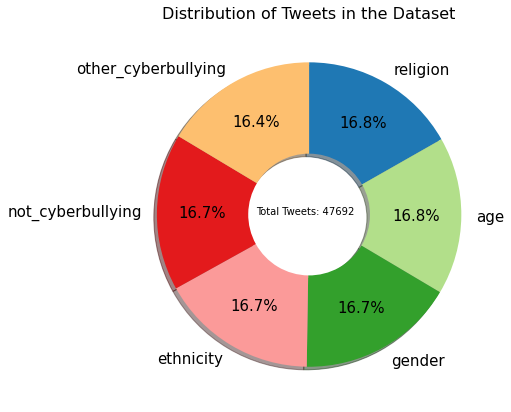

In [122]:
plt.figure(figsize = (7,7))
sorted_counts = data['cyberbullying_type'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[1:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(data.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

# preprocessing

In [3]:
##############################
####### SKIP THIS CELL #######
##############################

# text preprocessing ... building the functionality 
def remove_punctuation(tweet):
    tweet="".join([i for i in tweet if i not in string.punctuation])
    return tweet
#storing the puntuation free text
data['clean_tweet1']= data['tweet_text'].apply(lambda x:remove_punctuation(x))
data.head()

# convert to lowercase using regex
def lowercase(tweet):
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
data['clean_tweet2']= data['clean_tweet1'].apply(lambda x: x.lower())
data.head()

# tokenization

def tokenization(text):
    #tokens = re.split('W+',text)
    tokens = word_tokenize(text)
    tweet = [i for i in tokens]   
    return tweet
#applying function to the column
data['tokenized_tweet']= data['clean_tweet2'].apply(lambda x: tokenization(x))

# stopword removal
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(tweet):
    tweet= [i for i in tweet if i not in stopwords]
    return tweet

data['no_stopwords']= data['tokenized_tweet'].apply(lambda x:remove_stopwords(x))


# stemming
stemmer = PorterStemmer()

def stemming(tweet):
    tweet = [stemmer.stem(word) for word in tweet]
    return tweet

data['tweet_stemmed']=data['no_stopwords'].apply(lambda x: stemming(x))

# Lemmatization to ensure word meaning not lost during stemming
wnl = WordNetLemmatizer()

def lemmatizer(tweet):
    tweet = [wnl.lemmatize(word) for word in tweet]
    return tweet
data['tweet_lemmatized']=data['no_stopwords'].apply(lambda x:lemmatizer(x))

KeyboardInterrupt: 

In [3]:
#############################
####### RUN THIS CELL #######
#############################

# create a function to do all preprocessing in one step

def preprocessing(tweet):
    # punctuation
    tweet="".join([i for i in tweet if i not in string.punctuation])
    # lowercase
    regexp_pattern="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    tweet = re.sub(regexp_pattern, ' ', str(tweet).lower()).strip()
    # tokenize
    tokens = word_tokenize(tweet)
    tweet = [i for i in tokens]   
    # remove stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    tweet = [i for i in tweet if i not in stopwords]
    # stemming
    stemmer = PorterStemmer()
    tweet = [stemmer.stem(word) for word in tweet]
    # lemmatizer
    wnl = WordNetLemmatizer()
    tweet = [wnl.lemmatize(word) for word in tweet]
    
    return tweet

data['preprocessed_tweet'] = data['tweet_text'].apply(lambda x:preprocessing(x))

In [125]:
data.head(20)

,tweet_text,cyberbullying_type,preprocessed_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[word, katandandr, food, crapilici, mkr]"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[aussietv, white, mkr, theblock, imacelebritya..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[xochitlsuckkk, classi, whore, red, velvet, cu..."
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[jasongio, meh, p, thank, head, concern, anoth..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[rudhoeenglish, isi, account, pretend, kurdish..."
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,"[raja5aab, quickieleak, ye, test, god, good, b..."
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,"[itu, sekolah, ya, bukan, tempat, bulli, ga, j..."
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,"[karma, hope, bite, kat, butt, nasti, mkr]"
8,@stockputout everything but mostly my priest,not_cyberbullying,"[stockputout, everyth, mostli, priest]"
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,"[rebecca, black, drop, school, due, bulli]"


# one hot encore for binary class

In [30]:
# X = [['gender', 1], ['religion', 1], ['age', 1], ['ethnicity', 1], ['other_cyberbullying',1], ['not_cyberbullying', 0]]
# print("X: ",X)
# binary encode
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(X)
# enc.categories_

[array(['age', 'ethnicity', 'gender', 'not_cyberbullying',
        'other_cyberbullying', 'religion'], dtype=object),
 array([0, 1], dtype=object)]

In [7]:
# data['cyberbullying_binary_class'] = data['cyberbullying_type'].replace(['not_cyberbullying'],'0' ['ethnicity','other_cyberbullying','gender','age','gender','religion'],'1')
# data['cyberbullying_binary_class'] = np.where((data['cyberbullying_binary_class'] == 'not_cyberbullying'), 0, data['cyberbullying_binary_class'])
data['cyberbullying_binary_class'] = data['cyberbullying_type'].replace(dict.fromkeys(['ethnicity','other_cyberbullying','gender','age','gender','religion'], '1'))
print("After replacing the values:")
data

After replacing the values:


,tweet_text,cyberbullying_type,preprocessed_tweet,cyberbullying_binary_class
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[word, katandandr, food, crapilici, mkr]",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[aussietv, white, mkr, theblock, imacelebritya...",not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[xochitlsuckkk, classi, whore, red, velvet, cu...",not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[jasongio, meh, p, thank, head, concern, anoth...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[rudhoeenglish, isi, account, pretend, kurdish...",not_cyberbullying
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,"[black, ppl, arent, expect, anyth, depend, any...",1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,"[turner, withhold, disappoint, turner, call, c...",1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,"[swear, god, dumb, nigger, bitch, got, bleach,...",1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,"[yea, fuck, rt, therealexel, your, nigger, fuc...",1


In [8]:
data['cyberbullying_binary_class'] = data['cyberbullying_binary_class'].replace(dict.fromkeys(['not_cyberbullying'], '0'))
print("After replacing the values:")
data

After replacing the values:


,tweet_text,cyberbullying_type,preprocessed_tweet,cyberbullying_binary_class
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[word, katandandr, food, crapilici, mkr]",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[aussietv, white, mkr, theblock, imacelebritya...",0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[xochitlsuckkk, classi, whore, red, velvet, cu...",0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[jasongio, meh, p, thank, head, concern, anoth...",0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[rudhoeenglish, isi, account, pretend, kurdish...",0
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,"[black, ppl, arent, expect, anyth, depend, any...",1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,"[turner, withhold, disappoint, turner, call, c...",1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,"[swear, god, dumb, nigger, bitch, got, bleach,...",1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,"[yea, fuck, rt, therealexel, your, nigger, fuc...",1


In [175]:
# # importing one hot encoder 
# from sklearn.preprocessing import OneHotEncoder

# X = [['cyberbullying',1], ['not_cyberbullying', 0]]
# print("X: ",X)
# #binary encode
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(X)
# enc.categories_
# enc.transform([['cyberbullying',1], ['not_cyberbullying', 0]]).toarray()
# enc.inverse_transform([[1, 1, 0, 0],  [0, 0, 1, 0]])
# enc.get_feature_names(['cyberbullying_binary_class', 'group'])
# data

X:  [['cyberbullying', 1], ['not_cyberbullying', 0]]


,tweet_text,cyberbullying_type,preprocessed_tweet,cyberbullying_binary_class
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[word, katandandr, food, crapilici, mkr]",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[aussietv, white, mkr, theblock, imacelebritya...",not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[xochitlsuckkk, classi, whore, red, velvet, cu...",not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[jasongio, meh, p, thank, head, concern, anoth...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[rudhoeenglish, isi, account, pretend, kurdish...",not_cyberbullying
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,"[black, ppl, arent, expect, anyth, depend, any...",cyberbullying
47688,Turner did not withhold his disappointment. Tu...,ethnicity,"[turner, withhold, disappoint, turner, call, c...",cyberbullying
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,"[swear, god, dumb, nigger, bitch, got, bleach,...",cyberbullying
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,"[yea, fuck, rt, therealexel, your, nigger, fuc...",cyberbullying


In [9]:
(unique, counts) = np.unique(data['cyberbullying_binary_class'], return_counts=True)
print('Unique values of the target variable', unique)
print('Counts of the target variable :', counts)


Unique values of the target variable ['0' '1']
Counts of the target variable : [ 7945 39747]


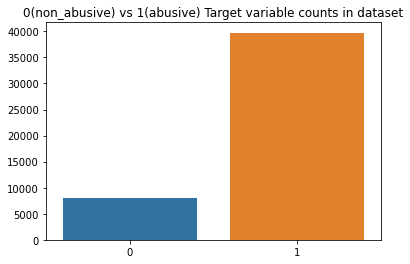

In [10]:
my_xticks = ['not_abusive','abusive']

sns.barplot(x=unique, y=counts)
plt.title('0(non_abusive) vs 1(abusive) Target variable counts in dataset')
plt.show()


In [5]:
# convert list to string for TF IDF

data['tweet_str'] = [','.join(map(str, l)) for l in data['preprocessed_tweet']]
data.head()

,tweet_text,cyberbullying_type,preprocessed_tweet,tweet_str
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[word, katandandr, food, crapilici, mkr]","word,katandandr,food,crapilici,mkr"
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[aussietv, white, mkr, theblock, imacelebritya...","aussietv,white,mkr,theblock,imacelebrityau,tod..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[xochitlsuckkk, classi, whore, red, velvet, cu...","xochitlsuckkk,classi,whore,red,velvet,cupcak"
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[jasongio, meh, p, thank, head, concern, anoth...","jasongio,meh,p,thank,head,concern,anoth,angri,..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[rudhoeenglish, isi, account, pretend, kurdish...","rudhoeenglish,isi,account,pretend,kurdish,acco..."


In [12]:
# fully cleaned
data.shape

(47692, 5)

# Multi-class Feature Selection & Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = data.tweet_str
y = data.cyberbullying_type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33384,) (14308,) (33384,) (14308,)


In [15]:
X_train, X_test, y_train, y_test

(12276    marleygotboob,gay,r,sissi,st8,men,r,run,prison...
 17518    newsflashthat,evilanglisti,christian,deplor,ra...
 4127     ncweaver,ive,ran,difficulti,get,respond,weird,...
 19027    satir,free,speech,pretend,solv,noth,problem,qu...
 23449    know,histor,burn,book,nazi,radic,christian,one...
                                ...                        
 11284    femal,like,roseann,barr,2,hideou,bitch,call,ch...
 44732    it,question,dumb,telli,tubbi,ya,clit,fat,pussi...
 38158    one,kid,turn,leftist,like,bulli,friend,kid,im,...
 860      rt,ravenhuwolf,univers,texasarlington,muslim,s...
 15795    doctrinedark798,abl,save,hereright,click,hold,...
 Name: tweet_str, Length: 33384, dtype: object,
 40362    goreejuhssgun,hahaha,aint,even,worth,tweet,dum...
 15019    rt,hsaymssik,suck,smile,wipe,face,huh,kat,glas...
 46321    remind,absolut,disgust,see,peopl,would,prank,c...
 23927    rt,buzzfeeduk,accident,open,front,camera,httpt...
 1640                                 love,look,frit

# TF IDF matrix

In [7]:
#tf idf vectorizer 
tf_idf = TfidfVectorizer()

#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train)

#applying tf idf to training data
X_train_tf = tf_idf.transform(X_train)

In [8]:
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 33384, n_features: 43018


In [9]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(X_test)

In [19]:
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 14308, n_features: 43018


In [27]:
print("TF.IDF matrix:\n\n",X_test_tf)

TF.IDF matrix:

   (0, 42139)	0.34765924613902005
  (0, 39753)	0.24860440561021702
  (0, 27926)	0.1529300223425951
  (0, 27908)	0.25833377043494893
  (0, 22978)	0.43658869866483874
  (0, 15175)	0.3426866651827557
  (0, 13444)	0.14177950939025594
  (0, 11858)	0.21122944007865876
  (0, 10875)	0.1550449670936286
  (0, 10506)	0.1794991269085139
  (0, 9996)	0.4140722893108974
  (0, 2337)	0.19846717221170293
  (0, 1758)	0.2955298019941715
  (1, 41883)	0.3419105123865329
  (1, 38753)	0.283051136614599
  (1, 37022)	0.2645530200825739
  (1, 36759)	0.3183140133668512
  (1, 35773)	0.33360504088740084
  (1, 33491)	0.14972022530585335
  (1, 26378)	0.29235175297431953
  (1, 26375)	0.17089375387583505
  (1, 22342)	0.23302188930687887
  (1, 19258)	0.3100653872195761
  (1, 16359)	0.26201263806933067
  (1, 14329)	0.3285198715715377
  :	:
  (14305, 27529)	0.4831048971002629
  (14305, 13444)	0.1531357480529151
  (14305, 4100)	0.40385999378984644
  (14306, 42105)	0.25153068981982535
  (14306, 40476)	0.2284

In [10]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [15]:
# KNN bagging

KNNbagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(KNNbagging, X_train_tf, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [17]:
# KNN Bagging performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.625 (0.016)


# Multinomial Naive Bayes

In [29]:
#naive bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)

MultinomialNB()

In [30]:
#predicted y
y_pred = naive_bayes_classifier.predict(X_test_tf)

In [31]:
# remind of target names
data['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [32]:
print(metrics.classification_report(y_test, y_pred, target_names=['religion','age','gender','ethnicity','not_cyberbullying','other_cyberbullying']))

                     precision    recall  f1-score   support

           religion       0.66      0.99      0.79      2349
                age       0.84      0.89      0.87      2418
             gender       0.81      0.85      0.83      2343
          ethnicity       0.72      0.33      0.46      2466
  not_cyberbullying       0.66      0.44      0.53      2391
other_cyberbullying       0.76      0.98      0.85      2341

           accuracy                           0.74     14308
          macro avg       0.74      0.75      0.72     14308
       weighted avg       0.74      0.74      0.72     14308



In [33]:
# check confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[2318    8    4    1    1   17]
 [ 129 2163   19    1   10   96]
 [  76   68 1996   82   57   64]
 [ 506  132  216  823  460  329]
 [ 453  203  228  232 1043  232]
 [  25    7   10   12    3 2284]]


# SVM binary classifier

In [34]:
from sklearn.model_selection import train_test_split

X_bi = data.tweet_str
y_bi = data.cyberbullying_binary_class
X_train, X_test, y_train, y_test = train_test_split(X_bi, y_bi, test_size=0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33384,) (14308,) (33384,) (14308,)


In [35]:
X_train, X_test, y_train, y_test

(12276    marleygotboob,gay,r,sissi,st8,men,r,run,prison...
 17518    newsflashthat,evilanglisti,christian,deplor,ra...
 4127     ncweaver,ive,ran,difficulti,get,respond,weird,...
 19027    satir,free,speech,pretend,solv,noth,problem,qu...
 23449    know,histor,burn,book,nazi,radic,christian,one...
                                ...                        
 11284    femal,like,roseann,barr,2,hideou,bitch,call,ch...
 44732    it,question,dumb,telli,tubbi,ya,clit,fat,pussi...
 38158    one,kid,turn,leftist,like,bulli,friend,kid,im,...
 860      rt,ravenhuwolf,univers,texasarlington,muslim,s...
 15795    doctrinedark798,abl,save,hereright,click,hold,...
 Name: tweet_str, Length: 33384, dtype: object,
 40362    goreejuhssgun,hahaha,aint,even,worth,tweet,dum...
 15019    rt,hsaymssik,suck,smile,wipe,face,huh,kat,glas...
 46321    remind,absolut,disgust,see,peopl,would,prank,c...
 23927    rt,buzzfeeduk,accident,open,front,camera,httpt...
 1640                                 love,look,frit

In [36]:
# binary TF IDF
#tf idf vectorizer 
tf_idf = TfidfVectorizer()

#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train)

#applying tf idf to training data
X_train_tf = tf_idf.transform(X_train)

#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(X_test)

# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [38]:
# linear SVM classifier
from sklearn.svm import LinearSVC
SVM = LinearSVC()
SVM.fit(X_train_tf, y_train)

#predicted y
y_pred = SVM.predict(X_test_tf)

print(metrics.classification_report(y_test, y_pred, target_names=['1','0']))

              precision    recall  f1-score   support

           1       0.61      0.45      0.52      2466
           0       0.89      0.94      0.92     11842

    accuracy                           0.86     14308
   macro avg       0.75      0.70      0.72     14308
weighted avg       0.84      0.86      0.85     14308



In [39]:
# check confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[ 1121  1345]
 [  702 11140]]
